# Análise de dados e Machine Learning

### O objetivo desde projeto é reunir em um só lugar todas as competências básicas de um cientista de dados.
### O modelo foi feito para a competição House Prices - Advanced Regression Techniques (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

# Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import MEstimateEncoder

# Carregamento dos dados

#### Usaremos o Ames Housing Dataset, disponibilizado no Kaggle, para a competição House Prices - Advanced Regression Techniques(https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). Ele contém dados de casas em Ames, Iowa.
#### Nosso principal objetivo é fazer uma análise exploratória das casas, além da visualização dos dados.
#### Precisamos, também, eliminar os outliers.

In [2]:
X_original = pd.read_csv('train.csv', index_col='Id')
X_full = pd.read_csv('train.csv', index_col='Id')
X_test_full = pd.read_csv('test.csv', index_col='Id')

#### Os dados estão divididos entre 'test.csv' e 'train.csv'.
#### O dataset de treino possui os preços das casas, assim podemos treinar o modelo preditivo.
#### Mas, para isso, precisamos remover e guardar esses dados e evitar contaminação.
#### Os dados de teste não possuem preços, além de serem uma continuação do dataset de treino, ou seja, compartilham a mesma coluna de id's.

In [3]:
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

#### Aqui verificamos o formato dos dados. Se treino e teste possuirem formatos diferentes, o modelo não poderá ser treinado. 
#### O formato correto dos dados é: X_test_full(1459,079); y(1460,); X_full(1460,79)

In [4]:
print(f'X_test_full data shape: {X_test_full.shape}')
print(f'y data shape: {y.shape}')
print(f'X_full data shape: {X_full.shape}')

X_test_full data shape: (1459, 79)
y data shape: (1460,)
X_full data shape: (1460, 79)


# Visualização dos dados

#### Aqui, veremos melhor nossos dados. Começamos pelo início, colunas, missing values, mais informações sobre os preços das casas, correlações, scatterplots e outliers.
#### A abordagem será simples: não vamos descartar nenhuma coluna, nem aprofundar a análise. Também não vamos retirar nenhum outlier, só precisamos saber da sua existência.
#### Veremos a correlação de cada variável ao preço final dos imóveis.
#### Não vamos tocar nos missing values por enquanto, isso será feito na próxima seção.

### Início dos dados

In [5]:
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Colunas

In [6]:
print(X_full.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Missing values
#### Em uma análise aprofundada, deveriamos decidir se vale a pena manter a coluna 'LotFrontage'. São 259, de 1460 casas, sem dados sobre a área frontal do terreno, ou seja, 17% da coluna está vazia, e somente preenchê-los com a média da coluna não parece ser a melhor opção. Também seria arriscado descartá-la, afinal a área frontal é um valor importante, mas só teremos certeza após a análise de correlações.

In [7]:
X_full.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 79, dtype: int64

### Descrição dos preços de venda

In [8]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## Gráfico de dispersão com os preços das casas e outliers

<AxesSubplot: xlabel='Id', ylabel='SalePrice'>

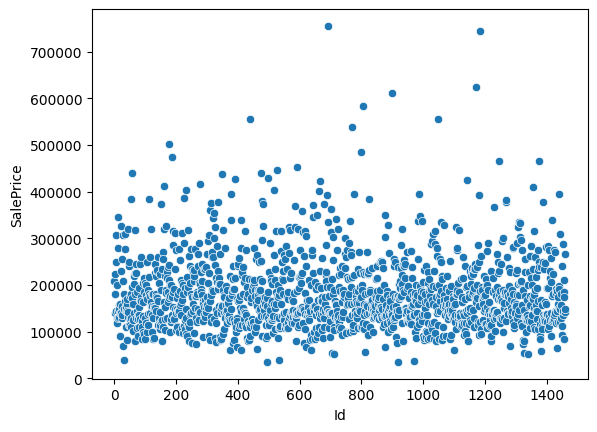

In [9]:
sns.scatterplot(data=X_original, x='Id', y='SalePrice')

In [10]:
outliers = X_original[X_original['SalePrice'] > 650000]
print(outliers)

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
692           60       RL        104.0    21535   Pave   NaN      IR1   
1183          60       RL        160.0    15623   Pave   NaN      IR1   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
692          Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
1183         Lvl    AllPub    Corner  ...      555     Ex  MnPrv         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
692        0      1    2007        WD         Normal     755000  
1183       0      7    2007        WD        Abnorml     745000  

[2 rows x 80 columns]


## Mapa de calor com correlação das variáveis

C:\Users\Original\AppData\Local\Temp\ipykernel_4940\2197439555.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(X_original.corr(), vmin=-1, vmax=1, annot=True)


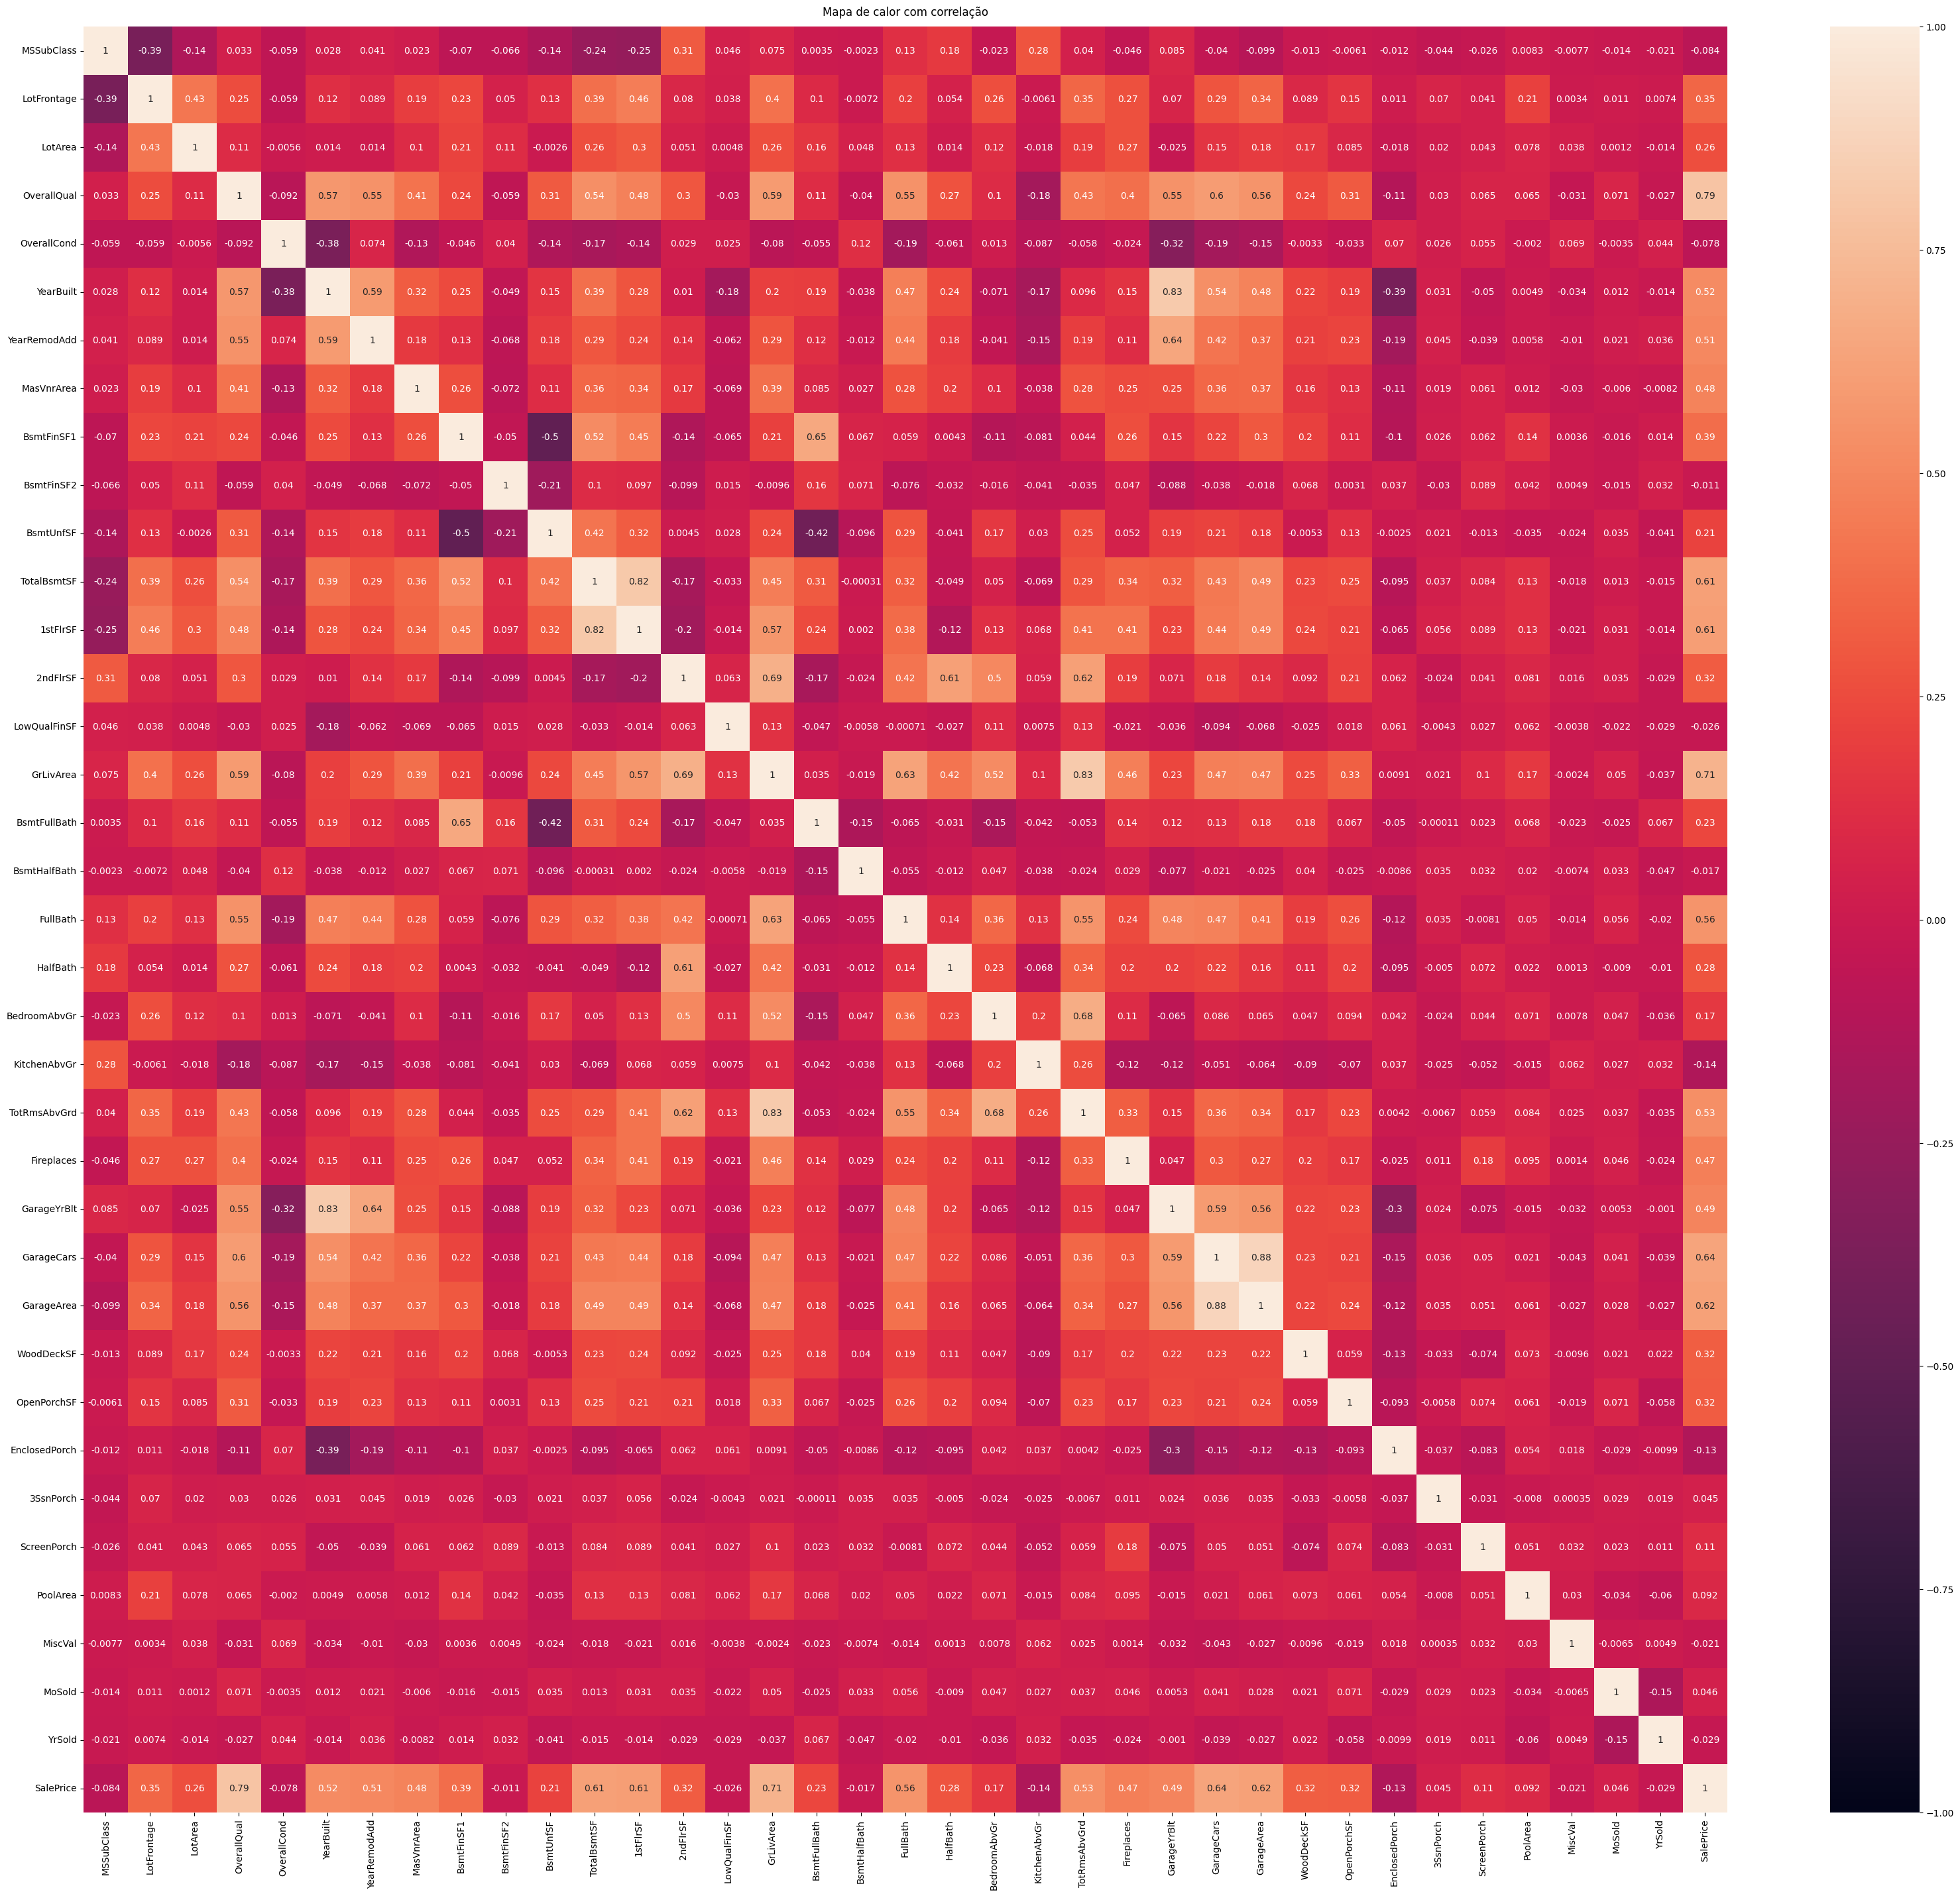

In [11]:
plt.figure(figsize=(40,35))
heatmap = sns.heatmap(X_original.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Mapa de calor com correlação', fontdict={'fontsize':12}, pad=12);
plt.savefig('HeatmapCorrelation.png', dpi=300)

### Aparentemente, nenhuma variável parece ter uma correlação muito forte e destacável em relação aos valores de venda.
### Vamos manter todas as colunas normalmente.

# Tratamento dos dados

## Train and Test Split
#### Vamos dividir nosso dataset para treino e validação

In [12]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2, random_state=0)

## Seleção de colunas (categóricas e numéricas)
#### Aqui, separamos as colunas de dados categóricos dos numéricos. Isso deve ser feito para preencher os valores nulos ou ausentes nos dois datasets.
#### Nossa abordagem será a mais simples possível: nos valores numéricos, usaremos a média de cada coluna para preencher os vazios.
#### Nas colunas de dados categóricos, vamos selecionar apenas colunas com baixa cardinalidade, ou seja, colunas com menos valores únicos. Usamos o SimpleImputer para preencher valores faltantes de cada coluna com o seu valor mais frequente. Depois, usamos OneHotEncoder para transformar essas colunas em dados binários, criando mais colunas para simplificar os dados.

In [13]:
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]


numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]


my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

## Tratamento de valores ausentes e preparação do modelo
#### Aqui, preenchemos os valores ausentes e preparamos uma Pipeline para facilitar tudo, assim podemos aplicar o mesmo modelo a outros datasets.

In [14]:
numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Modelo com XGBRegressor e ajuste de hyperparâmetros. Esses foram os melhores que pude encontrar.
#### Usaremos ele para fazer as previsões por um simples motivo: é melhor custo-benefício. Já testei regressão linear, redes neurais artificiais e modelos de árvore de decisão, e o XGBoost é melhor usando menos processamento.
#### Agora, passamos os dados pela Pipeline, fazendo as previsões em seguida, além de verificar a eficiência do modelo em relação aos dados reais.
#### Neste projeto utilizamos Erro Médio Absoluto, calculado a partir da média dos erros, para validação.

In [15]:
model_mk2 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=4, n_estimators=7500)

pipeline_mk2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model_mk2)
                     ])

pipeline_mk2.fit(X_train, y_train)

mk2_preds = pipeline_mk2.predict(X_valid)

print('mk2 MAE:', mean_absolute_error(y_valid, mk2_preds))

mk2 MAE: 15375.093134631848


In [16]:
# model_mk2 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=4, n_estimators=4500)
# mk2 MAE: 15488.651460830479

# model_mk2 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=4, n_estimators=5500)
# mk2 MAE: 15485.14960134846

# model_mk2 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=4, n_estimators=6500)
# mk2 MAE: 15473.784821810788

# model_mk2 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=4, n_estimators=5500)
# mk2 MAE: 15378.602244755994

# model_mk2 = XGBRegressor(colsample_bytree=0.4, learning_rate=0.03, max_depth=4, n_estimators=6500)
# mk2 MAE: 15375.135100064212

# Output

#### Essa é a última seção do projeto. Alimentamos o modelo com os dados de teste, ou seja, os dados oficiais da competição, e armazenamos as previsões em um .csv para a entrega.

In [18]:
mk2_test_predictions = pipeline_mk2.predict(X_test)
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': mk2_test_predictions})
output.to_csv('submission_mk2.csv', index=False)

## Dump do modelo para deploy

In [19]:
import joblib
joblib.dump(model_mk2, 'modelo_mk2.pkl')

['modelo_mk2.pkl']